**Learning Rate Finder for Keras**

Here I demonstrate a method for determining the optimal learning rate for your neural network.
*  https://github.com/surmenok/keras_lr_finder
*  https://arxiv.org/abs/1506.01186

*Step 1.1: Import Modules*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
from PIL import Image
import sklearn as sklearn
from sklearn.metrics import confusion_matrix
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier as MLPC
from sklearn import model_selection
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras import initializers, layers, models
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.utils.vis_utils import plot_model
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


*Step 1.2: Load Data*

In [2]:
data = pd.read_csv('../input/train.csv')
testingData = pd.read_csv('../input/test.csv')
X = data.drop("label",axis=1).values
y = data.label.values

def describeDataset(features,labels):
    print("\n'X' shape: %s."%(features.shape,))
    print("\n'y' shape: %s."%(labels.shape,))
    print("\nUnique elements in y: %s"%(np.unique(y)))
describeDataset(X,y)


'X' shape: (42000, 784).

'y' shape: (42000,).

Unique elements in y: [0 1 2 3 4 5 6 7 8 9]


*Step 1.3: Display Data*

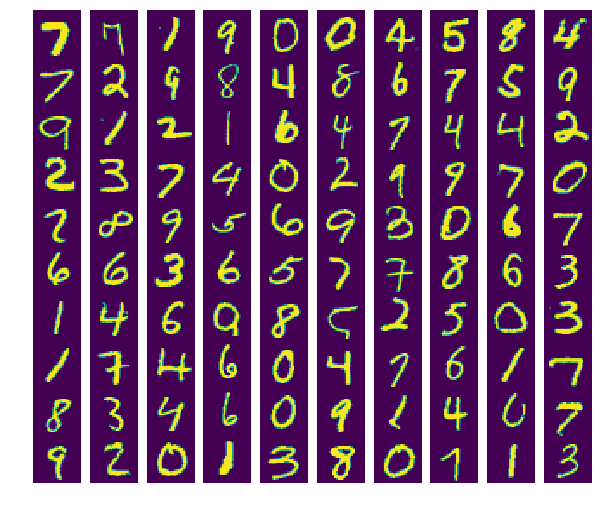

In [3]:
def displayMNIST(flatData,labels):
    """Display MNIST data"""
    flatData2 = data.drop("label",axis=1).values
    X2 = np.insert(flatData2,0,1,axis=1)
    figure,image = plt.subplots(1,10, figsize=(10,10))
    for i in range(10):
        tenImages = np.random.choice(X2.shape[0], 10)
        image[i].imshow(X2[tenImages,1:].reshape(-1,28))
        image[i].axis('off')
displayMNIST(X,y)

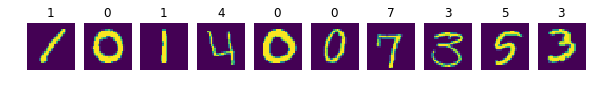

In [4]:
def displayMNIST2(flatData,labels):
    """ Displays 10 handwritten digis and 10 classification labels """
    figure,image = plt.subplots(1,10, figsize=(10,10))
    for i in range(10):
        image[i].imshow(flatData[i].reshape((28,28)))
        image[i].axis('off')
        image[i].set_title(labels[i])
displayMNIST2(X,y)

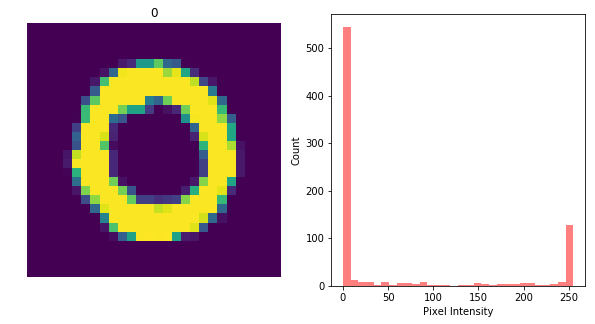

In [5]:
X3 = X[1].reshape((28,28))
def pixelIntensities(flatData,labels):
    """Plot histogram of Pixel Intensities"""
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(flatData)
    plt.axis('off')
    plt.title(labels[1])
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(flatData[:,:].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
pixelIntensities(X3,y)

*Step 2: Preprocess Data*

In [6]:
X = data.iloc[:,1:] # everything but the first column  (pixel values)
y = data.iloc[:,:1] # first column only  (label/answer)

xValues = X
yValues = y.values.ravel()
x_train, x_test, y_train, y_test = train_test_split(xValues, yValues, test_size=0.2, random_state=23)

x_train = x_train/ 256 # normalize values between zero and one
x_test = x_test / 256

# Reshape images from 1D flattened images to normal 2D images
img_rows, img_cols = 28, 28
if K.image_data_format() == 'channels_first':
    x_trainReshaped = x_train.values.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_testReshaped = x_test.values.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_trainReshaped = x_train.values.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_testReshaped = x_test.values.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_trainReshaped = x_trainReshaped.astype('float32')
x_testReshaped = x_testReshaped.astype('float32')

# convert class vectors to binary class matrices
num_classes = 10
y_trainReshaped = keras.utils.to_categorical(y_train, num_classes)
y_testReshaped = keras.utils.to_categorical(y_test, num_classes)
    
describeDataset(x_trainReshaped,y_trainReshaped)


'X' shape: (33600, 28, 28, 1).

'y' shape: (33600, 10).

Unique elements in y: [0 1 2 3 4 5 6 7 8 9]


*Step 3: Define Helper Functions*

In [ ]:
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

dict_characters = {0: '0', 1: '1', 2: '2', 
        3: '3', 4: '4', 5: '5', 6: '6', 7:'7',
        8: '8', 9: '9'}

from matplotlib import pyplot as plt
import math
from keras.callbacks import LambdaCallback
import keras.backend as K


class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if math.isnan(loss) or loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        num_batches = epochs * x_train.shape[0] / batch_size
        self.lr_mult = (end_lr / start_lr) ** (1 / num_batches)

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                        batch_size=batch_size, epochs=epochs,
                        callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale('log')

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivative = (self.losses[i] - self.losses[i - sma]) / sma
            derivatives.append(derivative)

        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], derivatives[n_skip_beginning:-n_skip_end])
        plt.xscale('log')
        plt.ylim(y_lim)


*Step 6: Determine Optimal Learning Rate*

In [ ]:
def determineLearningRate(xtrain,ytrain,xtest,ytest):    
    batch_size = 128
    num_classes = 10
    epochs = 5
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.SGD(),
                  metrics=['accuracy'])
    lr_finder = LRFinder(model)
    lr_finder.find(xtrain,ytrain, start_lr=0.0000001, end_lr=100, batch_size=512, epochs=5)
    lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)
    plt.show()
    return model
determineLearningRate(x_trainReshaped, y_trainReshaped,x_testReshaped,y_testReshaped)


Epoch 1/5
33600/33600 [==============================] - 65s 2ms/step - loss: 2.3010 - acc: 0.1214
Epoch 2/5
30720/33600 [==========================>...] - ETA: 5s - loss: 2.3007 - acc: 0.1225

It looks like a learning rate of 0.1 is best for the SGD optimizer.

*Step 7: Evaluate Model*

In [ ]:
learningRate=0.1
def runKerasCNN(xtrain,ytrain,xtest,ytest):    
    batch_size = 128
    num_classes = 10
    epochs = 5
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.SGD(lr=learningRate),
                  metrics=['accuracy'])
    model.fit(xtrain,ytrain,
              batch_size=batch_size,
              verbose=1,
              epochs=epochs,
              validation_data=(xtest,ytest),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(xtest,ytest, verbose=0)
    print('\nKeras Convolutional Neural Network - accuracy:', score[1],"\n")
    Y_pred = model.predict(xtest)
    print('\n', sklearn.metrics.classification_report(np.where(ytest > 0)[1], np.argmax(Y_pred, axis=1), target_names=list(dict_characters.values())), sep='')    
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    Y_true = np.argmax(ytest,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
    plotKerasLearningCurve()
    plt.show()
    return model
runKerasCNN(x_trainReshaped, y_trainReshaped,x_testReshaped, y_testReshaped)